In [206]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import linregress
from pytz import timezone
from pandas.tseries.offsets import BDay
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from prettytable import PrettyTable
import tqdm
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [250]:
# load data
# Download data from Yahoo Finance
tickers = ["XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLRE", "XLK", "XLU", "SPY"]

data_end_date = datetime.now() - timedelta(days = 1)
data_start_date = data_end_date - timedelta(days = 10 * 365)

folder = 'ProjectData'
if not os.path.exists(folder):
    os.mkdir(folder)

holder = {}
for ticker in tickers:

    file_name = f'{folder}/{ticker}.csv'
    if not os.path.exists(file_name):
        df = yf.Ticker(ticker).history(start = data_start_date.strftime("%Y-%m-%d"), end = data_end_date.strftime("%Y-%m-%d"))
        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True)
    df.index = df.index.tz_convert('US/Eastern')

    holder[ticker] = df

In [251]:
# Generate dfs with close prices, returns, and standardized returns
close_df = pd.concat(list(map(lambda x: x.Close, holder.values())), axis = 1)
close_df.columns = list(holder.keys())
open_df = pd.concat(list(map(lambda x: x.Open, holder.values())), axis = 1)
open_df.columns = list(holder.keys())
return_df = close_df.pct_change(axis = 0)
std_returns_df = (return_df - return_df.rolling(252, axis = 0).mean())/ return_df.rolling(252, axis = 0).std()
std_returns_df.dropna(inplace = True)

beta_df = pd.DataFrame()
benchmark_returns = return_df["SPY"]
for stock in return_df.columns:
    beta_df[stock] = return_df[stock].rolling(22).cov(benchmark_returns) / return_df[stock].rolling(22).var()
beta_df = beta_df.shift(1)


In [252]:
def get_residuals(data, N = 1):
    pca = PCA(n_components = N)
    pca.fit(data)
    index = pca.components_[0]
    mm = [sm.OLS(s, index).fit() for s in data.values]
    res = list(map(lambda x: x.resid.T, mm))
    return res

def z_score(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data) 

In [256]:
def simulation(start_date, end_date, open_simu, close_simu, max_position, initial_cash, min_data_points, benchmark_data, beta_hedge):
    '''
    Simulation function

    Assume trades will be opened during daily open and closed during daily close
    '''
    entry = {}
    pnls = []
    betas = []
    dates = []
    orders = {}
    slippage = 0.00025
    commission_fee = 0.005
    beta_limit = 0

    if open_simu.shape != close_simu.shape:
        return

    if max_position >= close_simu.shape[1] / 2:
        print("There's too many positions within the portfolio")
        return

    cash_value = initial_cash
    for i in range(close_simu.shape[0] + 1):
        if i < min_data_points:
            continue

        if i != close_simu.shape[0] and close_simu.index[i] < start_date:
            continue

        # Get Mark-to-Market Value of different positions after previous close
        pnl = 0
        for stock, position_info in entry.items():
            price, size = position_info.values()
            if stock != "hedge":
                pnl += (price - close_simu.iloc[i - 1, stock]) * size
            else:
                pnl += (price - benchmark_data.Close[i - 1]) * size
            pnl -= commission_fee * abs(size)

        cash_value += pnl
        pnls.append(pnl)

        orders[close_simu.index[i - 1]] = entry

        if i >= close_simu.shape[0] or close_simu.index[i] > end_date:
            break

        section_data = close_simu.iloc[i - min_data_points:i, :]
        if section_data.isna().sum().sum() > 0:
            continue

        # Getting residuals and z-scores based on previous close
        residuals = get_residuals(section_data, 2)
        residuals = np.stack(residuals, axis = 0)
        z_scores = z_score(residuals)
        zs = dict(enumerate(z_scores[-1, :], 1))


        # Opening the position according to open price of current time
        
        entry = {}
        idx_long = (np.argsort([zs[j] for j in zs])[:max_position])
        idx_short = (np.argsort([zs[j] for j in zs])[-max_position:])

        beta = 0
        
        for long, short in zip(idx_long, idx_short):
            long_entry_price = open_simu.iloc[i, long] * (1 + slippage)
            short_entry_price = open_simu.iloc[i, short] * (1 - slippage)
            entry[long] = {'price': long_entry_price, "size": np.round(cash_value / (max_position * long_entry_price))}
            entry[short] = {'price': short_entry_price, "size": - np.round(cash_value / (max_position * short_entry_price))}
            beta += (beta_df.iloc[i - 1, long] - beta_df.iloc[i - 1, short]) / max_position

        
        # Beta Hedge
        if beta_hedge and abs(beta) > beta_limit:
            abs_difference = abs(beta) - beta_limit
            hedge_direction = -1 if beta > 0 else 1
            entry_price = benchmark_data.Open[i] * (1 + slippage) if hedge_direction > 0 else benchmark_data.Open[i] * (1 - slippage)
            entry["hedge"] = {"price": entry_price, "size": np.round(abs_difference * cash_value / entry_price) * hedge_direction}
            beta += abs_difference * hedge_direction
        
        betas.append(beta)
        dates.append(close_simu.index[i])

    
    # Consolidate pnl data to df
    pd.options.display.float_format = "{:.3f}".format
    df = pd.DataFrame(pnls[1:], columns = ['daily_pnl'])
    df['ptf_value'] = initial_cash + df.daily_pnl.cumsum()
    df["ptf_beta"] = betas
    df.loc[-1] = [0, initial_cash, 0]
    df.index = df.index + 1
    df.sort_index(inplace = True)
    df.index = orders.keys()

    df['benchmark_close'] = benchmark_data.Close.loc[df.index]
    df['benchmark_val'] = df.benchmark_close / df.benchmark_close[0] * initial_cash
    df['ptf_return'] = df.ptf_value.pct_change()
    df['benchmark_return'] = df.benchmark_val.pct_change()
    

    return cash_value, df, orders




In [257]:
# Simulation setup
start_date = datetime(2019, 1, 1)
end_date = datetime(2024, 1, 1)
tz = timezone('EST')
start_date = start_date.replace(tzinfo = tz)
end_date = end_date.replace(tzinfo = tz)
open_simu = open_df.drop(columns = ["SPY"])
close_simu = close_df.drop(columns = ["SPY"])
benchmark_data = holder["SPY"]
initial_cash = 10e5

In [262]:
max_position = 2
min_data_points = 160
end_cash_value, df, orders = simulation(start_date, end_date, open_simu, close_simu, max_position, initial_cash, min_data_points, benchmark_data, False)

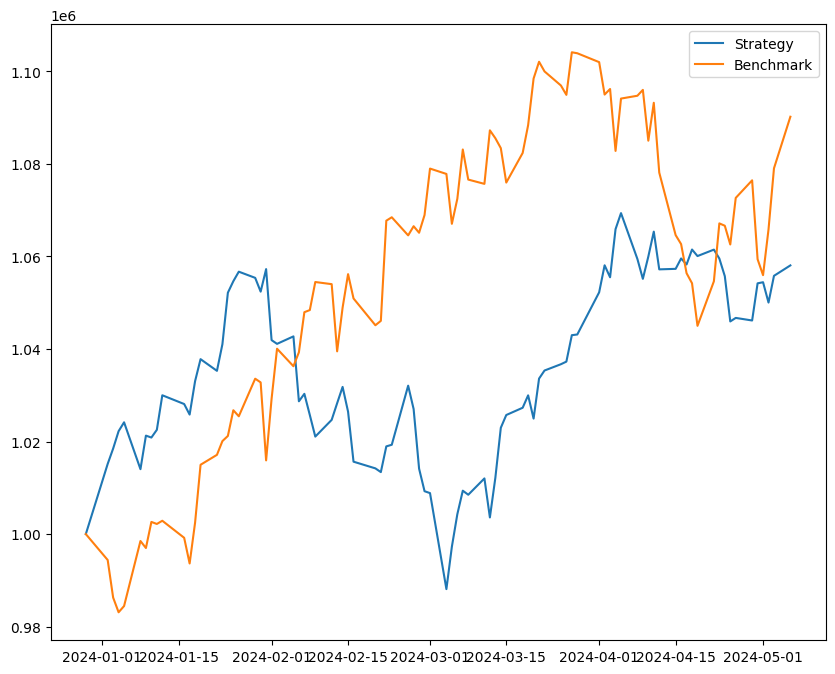

In [265]:
fig = plt.figure(figsize = (10, 8))
plt.plot(df.ptf_value, label = "Strategy")
plt.plot(df.benchmark_val, label = "Benchmark")
plt.legend()
plt.show()


In [217]:
# Descripitive Statistics

def backtest_statistics(final_df):
    ptf_returns = final_df.ptf_return.dropna()
    ptf_return = (final_df.ptf_value[-1] - final_df.ptf_value[0]) / final_df.ptf_value[0]
    avg_return = ptf_returns.mean()
    std_daily_return = ptf_returns.std()
    volatility = std_daily_return * np.sqrt(252)

    confidence_level = 0.95
    z_score_var = norm.ppf(confidence_level)
    VaR_percentage = - z_score_var * std_daily_return

    benchmark_returns = final_df.benchmark_return.dropna()
    model = sm.OLS(ptf_returns, sm.add_constant(benchmark_returns)).fit()
    alpha, beta = model.params

    sharpe = avg_return / std_daily_return * np.sqrt(252)

    window = 252
    roll_max = final_df.ptf_value.rolling(window, min_periods = 1).max()
    final_df['max_drawdown'] = final_df.ptf_value / roll_max - 1
    max_drawdown = -final_df.max_drawdown.min()

    statistics = {
        "ptf_return": ptf_return,
        "avg_return": avg_return,
        "volatility": volatility,
        "var": VaR_percentage,
        "maxdrawdown": max_drawdown,
        "alpha": alpha,
        "beta": beta,
        "sharpe": sharpe
    }
    return final_df, statistics

def create_table():
    # Display in table
    table = PrettyTable()
    table.field_names = ["Test Name", "Portfolio Return (%)", "Average Return (%)", "Volatility (%)", "VaR (%)", "MDD(%)","Alpha (%)", "Beta", "Sharpe Ratio"]
    return table

def add_data(table, data, test_name = "Backtest"):
    # Multiply all values except sharpe
    data = np.array(data)
    data[:-2] *= 100
    table.add_row([test_name] + list(data))
    return table

def display_table(table):
    print(table)


In [247]:
final_df, statistics = backtest_statistics(df)
table = create_table()
table = add_data(table, list(statistics.values()))
display_table(table)

+-----------+----------------------+---------------------+--------------------+---------------------+--------------------+---------------------+----------------------+--------------------+
| Test Name | Portfolio Return (%) |  Average Return (%) |   Volatility (%)   |       VaR (%)       |       MDD(%)       |      Alpha (%)      |         Beta         |    Sharpe Ratio    |
+-----------+----------------------+---------------------+--------------------+---------------------+--------------------+---------------------+----------------------+--------------------+
|  Backtest |  104.02480702592362  | 0.14694012612268043 | 15.105408532110987 | -1.5651626002992778 | 11.245067725887969 | 0.14864439121226025 | -0.12248097107615154 | 2.4513677802357767 |
+-----------+----------------------+---------------------+--------------------+---------------------+--------------------+---------------------+----------------------+--------------------+


In [237]:
def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

# Optimization

def optimize(start_date, end_date):
    max_pos_poss = list(range(1, 6))
    min_points_poss = list(range(10, 252, 10))
    all_possibilities = cartesian([max_pos_poss, min_points_poss])
    test_results = []
    
    for max_pos, min_point in tqdm.tqdm(all_possibilities):
        end_cash_value, final_df, orders = simulation(start_date, end_date, open_simu, close_simu, max_pos, initial_cash, min_point, benchmark_data, True)
        final_df, statistics = backtest_statistics(final_df)
        statistics = pd.DataFrame.from_dict(statistics, orient = "index").T
        statistics['max_pos'] = max_pos
        statistics['min_point'] = min_point
        test_results.append(statistics)

    return test_results

tz = timezone('EST')
optim_start_date = datetime(2019, 1, 1).replace(tzinfo = tz)
optim_end_date = datetime(2024, 1, 1).replace(tzinfo = tz)
    
test_results = optimize(optim_start_date, optim_end_date)
optim_res = pd.concat(test_results)
optim_res.sort_values(by = "ptf_return", ascending = False)
optim_res.to_csv("OptimizationResult.csv", index = False)

        

100%|██████████| 125/125 [59:15<00:00, 28.44s/it]   


In [239]:
optim_res.sort_values(by = "ptf_return", ascending = False)

,ptf_return,avg_return,volatility,var,maxdrawdown,alpha,beta,sharpe,max_pos,min_point
0,2.207,0.001,0.198,-0.021,0.222,0.001,-0.144,1.320,1,180
0,2.150,0.001,0.199,-0.021,0.187,0.001,-0.154,1.281,1,160
0,2.128,0.001,0.156,-0.016,0.132,0.001,-0.101,1.572,2,160
0,2.113,0.001,0.157,-0.016,0.150,0.001,-0.099,1.570,2,170
0,2.080,0.001,0.198,-0.020,0.224,0.001,-0.156,1.273,1,170
...,...,...,...,...,...,...,...,...,...,...
0,0.373,0.000,0.202,-0.021,0.306,0.000,-0.088,0.416,1,30
0,0.373,0.000,0.197,-0.020,0.335,0.000,-0.130,0.444,1,220
0,0.267,0.000,0.153,-0.016,0.349,0.000,-0.111,0.386,2,10
0,0.068,0.000,0.204,-0.021,0.250,0.000,-0.082,0.167,1,20
